In [36]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath('thinker/thinker')
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import namedtuple
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from collections import deque
import time
import numpy as np
import argparse
import torch
import torch.nn.functional as F
from thinker.env import Environment, EnvOut
from thinker.net import ActorNet, ModelNet
from thinker.buffer import ModelBuffer
from thinker.gym.asyn_vector_env import AsyncVectorEnv
import thinker.util as util
import gym
import gym_csokoban

def gplot(x, ax=None, title=None):
    if ax is None: fig, ax = plt.subplots()
    if type(x) == torch.Tensor: x = x.cpu()
    if type(x) == np.ndarray: x = torch.tensor(x)       
    ax.imshow(torch.swapaxes(torch.swapaxes(x,0,2),0,1), interpolation='nearest', aspect="auto")
    if title is not None: ax.set_title(title)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Exception: 0 [0] check not passed: gym_env_out 756524.000000

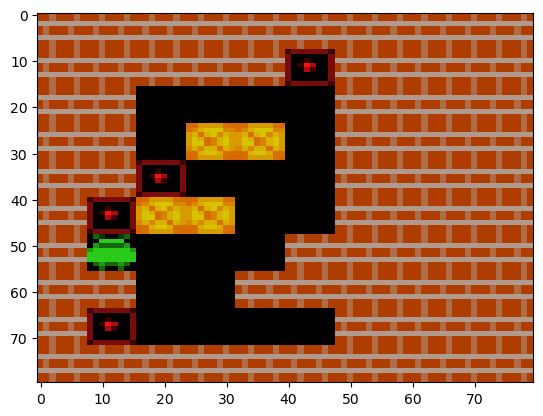

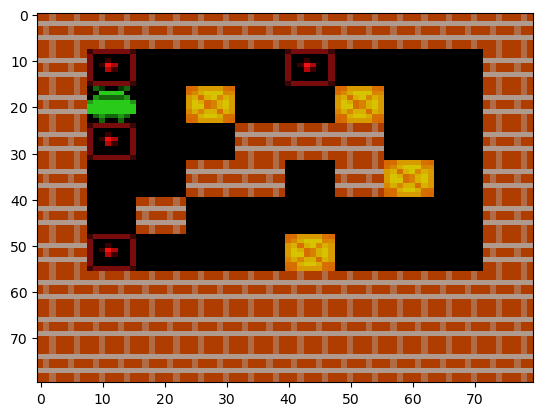

In [110]:
from thinker.util import Timings
import thinker.env

flags = util.parse([])
flags.rec_t = 5
flags.flex_t = False

model_net = ModelNet((3,80,80), 5, flags)
_ = model_net.train(False)

def check_diff(env_out, env_out_, ind, n):
    check = ['gym_env_out', 'model_out', 'reward', 'done', 
        'episode_return', 'episode_step', 'cur_t', 'last_action',
        'max_rollout_depth']
    for c in check:
        d = torch.sum(torch.abs(getattr(env_out, c)[:,[ind]].cpu().float() - getattr(env_out_, c).cpu().float()))
        if d > 1e-6:
            if not c == 'gym_env_out':
                print(getattr(env_out, c)[[d]], getattr(env_out_, c))
            else:
                gplot(getattr(env_out, 'gym_env_out')[0,ind].cpu())
                gplot(getattr(env_out_, 'gym_env_out')[0,0].cpu())
            raise Exception("%d [%d] check not passed: %s %f" %(n, ind, c, d))

torch.set_printoptions(precision=5)
env_n = 2
device = torch.device("cuda")

model_net_ = ModelNet((3,80,80), 5, flags)
model_net_.load_state_dict({k: v.cpu() for k, v in model_net.state_dict().items()})
model_net_.train(False)

env = Environment(flags, env_n=env_n, device=device)
env.seed(np.arange(env_n))
model_net.to(device)
env_out, _ = env.initial(model_net)

env_ = [Environment(flags) for _ in range(env_n)]
env_out_ = []
for n in range(env_n): 
    env_[n].seed([n])
    env_out_single, _ = env_[n].initial(model_net_)
    env_out_.append(env_out_single)
    check_diff(env_out, env_out_single, n, 0)

timings = Timings()

#for n in range(env_n): gplot(env_out.gym_env_out[0,n].cpu())

for n in range(1000):
    timings.reset()
    action = torch.tensor([[np.random.randint(5),
                            np.random.randint(5),
                            np.random.randint(2),
                            #np.random.randint(2)
                            ] for _ in range(env_n)])
    timings.time("s0")
    env_out, _ = env.step(action.unsqueeze(0).to(device), model_net, None)
    timings.time("s1")
    env_out_ = []
    for m in range(env_n):
        env_out_single, _ = env_[m].step(action.unsqueeze(0)[:,[m]], model_net_, None)
        env_out_.append(env_out_single)
        check_diff(env_out, env_out_single, m, n+1)
    timings.time("s2")
    
    if env_[0].env.baseline_max_q is not None:
        env_bmaxq = torch.tensor([e.env.baseline_max_q for e in env_])
        env_bmeanq = torch.tensor([e.env.baseline_mean_q for e in env_])
        diff_max_q = torch.sum(torch.abs(env.env.baseline_max_q.cpu() - env_bmaxq))
        diff_mean_q = torch.sum(torch.abs(env.env.baseline_mean_q.cpu() - env_bmeanq))
        if diff_max_q > 1e-6 or diff_mean_q > 1e-6:
            raise Exception("diff in max_q: %f mean_q %f" % (diff_max_q, diff_mean_q))

    last_env_out = env_out
    last_env_out_ = env_out_
    if n % 50 == 0: print(n)

print(timings.summary())    

In [ ]:
                    for m in range(self.num_p_actors):
                                if env_out.done[0,m]:
                                    x = env_out.gym_env_out[0,m]
                                    x = x.cpu()
                                    im = Image.fromarray(torch.swapaxes(torch.swapaxes(x,0,2),0,1).numpy())
                                    im.save("%d_%d_%d.png" % (self.rank, m, n))


In [103]:
from PIL import Image
def save_img(x, name):
    x = env_out.gym_env_out[0,0]
    x = x.cpu()
    im = Image.fromarray(torch.swapaxes(torch.swapaxes(x,0,2),0,1).numpy())
    im.save(name)


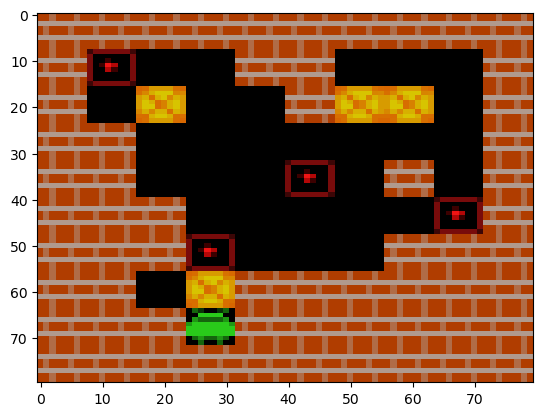

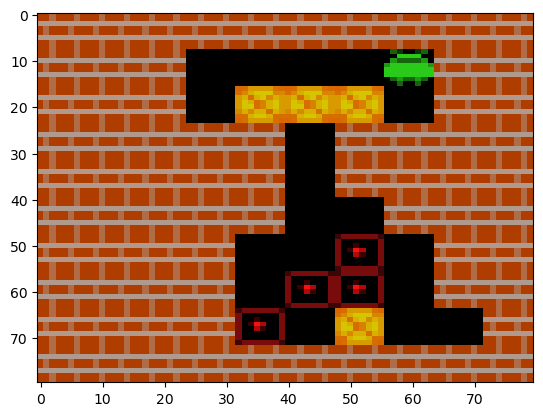

In [119]:
env_t = [Environment(flags), Environment(flags)]
env_t[0].seed([0])
env_t[1].seed([1])

env_out_t_0, _ = env_t[0].initial(model_net_)
#env_out_t_1, _ = env_t[1].initial(model_net_)
#env_t[1].env.env.reset()

done = False
gplot(env_out_t_0.gym_env_out[0,0])
#gplot(env_out_t_1.gym_env_out[0,0])
while(not done):
    env_out_t_0, _ = env_t[0].step(torch.tensor([[[0,0,0]]], dtype=torch.long), model_net_, None)
    #env_out_t_1, _ = env_t[1].step(torch.tensor([[[0,0,0]]], dtype=torch.long), model_net_, None)
    done = env_out_t_0.done
gplot(env_out_t_0.gym_env_out[0,0])

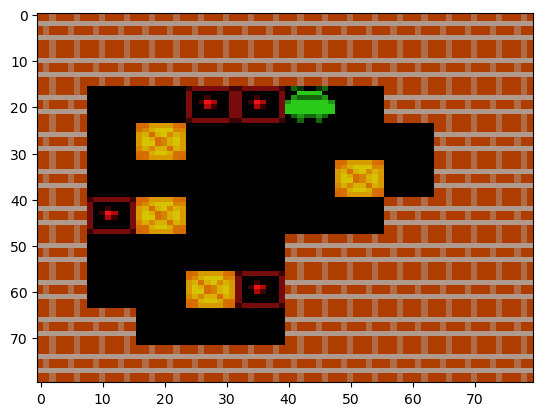

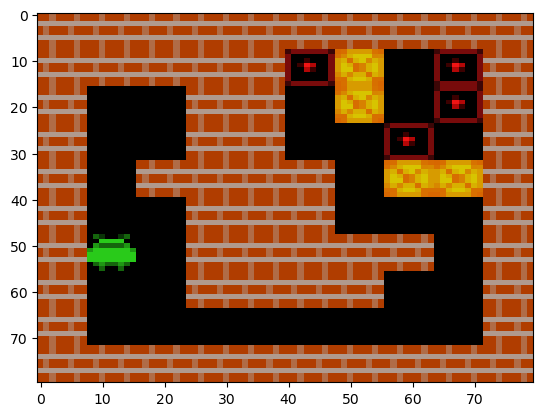

In [94]:
ind = 0
gplot(env_out.gym_env_out[0,ind])
gplot(env_out_[ind].gym_env_out[0,0])

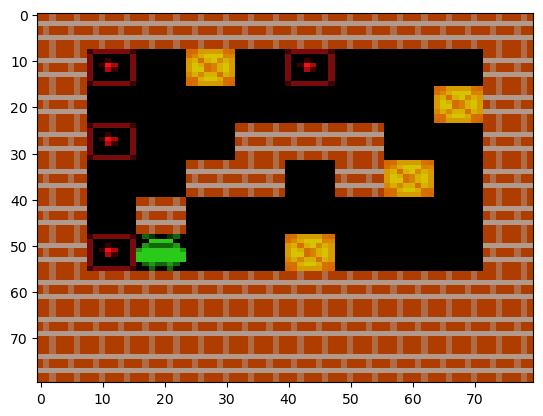

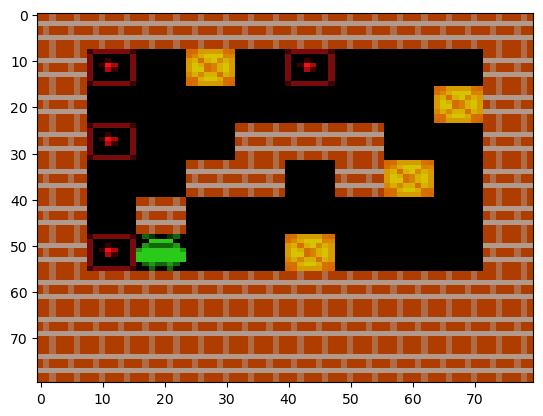

In [67]:
ind = 0
gplot(last_env_out.gym_env_out[0,ind])
gplot(last_env_out_[ind].gym_env_out[0,0])

[]

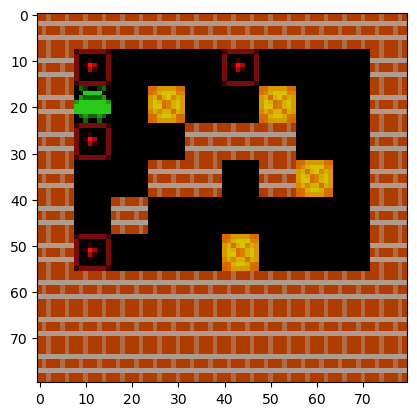

In [81]:
env = gym.make("cSokoban-v0")
env.seed(0)
done = True
obs = env.reset()
plt.imshow(obs)
plt.plot()

[]

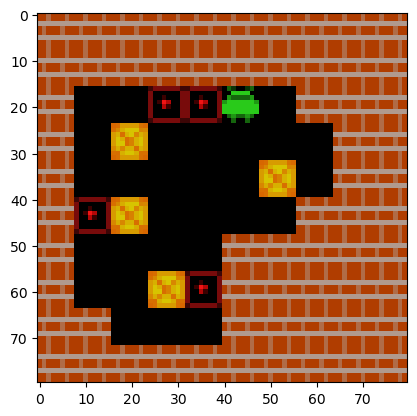

In [82]:
while(not done):
    obs, reward, done, info = env.step(2)
obs = env.reset()
plt.imshow(obs)
plt.plot()

In [44]:
from thinker.util import Timings
import thinker.env

flags = util.parse([])
flags.rec_t = 5
flags.flex_t = False

model_net = ModelNet((3,80,80), 5, flags)
_ = model_net.train(False)

def check_diff(env_out, env_out_, n):
    check = ['gym_env_out', 'model_out', 'reward', 'done', 
        'episode_return', 'episode_step', 'cur_t', 'last_action',
        'max_rollout_depth']
    for c in check:
        d = torch.sum(torch.abs(getattr(env_out, c)[:,[0]].cpu().float() - getattr(env_out_, c).cpu().float()))
        if d > 1e-6:
            if not c == 'gym_env_out':
                print(getattr(env_out, c)[[0]], getattr(env_out_, c))
            else:
                gplot(getattr(env_out, 'gym_env_out')[0,0])
                gplot(getattr(env_out_, 'gym_env_out')[0,0])
            raise Exception("%d check not passed: %s %f" %(n, c, d))

torch.set_printoptions(precision=5)
env_n = 2
device = torch.device("cuda")

model_net_ = ModelNet((3,80,80), 5, flags)
model_net_.load_state_dict({k: v.cpu() for k, v in model_net.state_dict().items()})
model_net_.train(False)

env = Environment(flags, env_n=env_n, device=device)
env.seed(np.arange(env_n)+1)
model_net.to(device)
env_out, _ = env.initial(model_net)

env_ = Environment(flags)
env_.seed([1])
env_out_, _ = env_.initial(model_net_)
check_diff(env_out, env_out_, 0)

timings = Timings()

for n in range(1000):
    timings.reset()
    action = torch.tensor([[np.random.randint(5),
                            np.random.randint(5),
                            np.random.randint(2),
                            #np.random.randint(2)
                            ] for _ in range(env_n)])
    timings.time("s0")
    env_out, _ = env.step(action.unsqueeze(0).to(device), model_net, None)
    timings.time("s1")
    env_out_, _ = env_.step(action.unsqueeze(0)[:,[0]], model_net_, None)
    timings.time("s2")
    check_diff(env_out, env_out_, n+1)
    if env_.env.baseline_max_q is not None:
        diff_max_q = torch.square(torch.abs(env.env.baseline_max_q.cpu()[0] - env_.env.baseline_max_q))
        diff_mean_q = torch.square(torch.abs(env.env.baseline_mean_q.cpu()[0] - env_.env.baseline_mean_q))
        if diff_max_q > 1e-6 or diff_mean_q > 1e-6:
            raise Exception("diff in max_q: %f mean_q %f" % (diff_max_q, diff_mean_q))
    if n % 50 == 0: print(n)

print(timings.summary())    

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950

    s2: 2.715745ms +- 1.201678ms (52.78%) 
    s1: 2.401991ms +- 0.670874ms (46.69%) 
    s0: 0.027248ms +- 0.016025ms (0.53%) 
Total: 5.144984ms


In [ ]:
import thinker.env
torch.set_printoptions(precision=5)
env_n = 2

env = AsyncVectorEnv([lambda: TransposeWrap((gym.make("cSokoban-v0"))) for _ in range(env_n)])
env.seed([0,0])
env = VecModelWrapper(env, env_n, flags)
model_out, gym_env_out = env.reset(model_net)

env_ = TransposeWrap((gym.make("cSokoban-v0")))
env_.seed(0)
env_ = thinker.env.ModelWrapper(env_, flags)
(gym_env_out_, model_out_), _ = env_.reset(model_net)

print("initial diff ", torch.sum(torch.absolute(model_out_-model_out[0])))

for n in range(100000):
    action = torch.tensor([[np.random.randint(5),
                            np.random.randint(5),
                            np.random.randint(2),
                            np.random.randint(2)
                            ] for _ in range(env_n)])
    action_1 = action.clone()
    (model_out, gym_env_out), reward, done, info = env.step(action, model_net)
    action_2 = action.clone()
    (gym_env_out_, model_out_), reward_, done_, info_, _ = env_.step(action[0].numpy(), model_net, None)
    action_3 = action.clone()
    if done_: (gym_env_out_, model_out_), _ = env_.reset(model_net)

    d_model_out = torch.sum(torch.absolute(model_out_- model_out[0]))
    d_gym_env_out = torch.sum(torch.absolute(torch.tensor(gym_env_out_) - gym_env_out[0]))
    d_reward = torch.sum(torch.absolute(torch.tensor(reward_) - reward[0]))
    d_done = torch.sum(torch.absolute(torch.tensor(done_, dtype=torch.float32) - done[0].float()))

    if d_model_out > 1e-5 or d_gym_env_out > 1 or d_reward > 1e-7 or d_done > 0.:
        raise Exception("%d unmatched output; d_model_out: %.6f d_gym_env_out %.6f d_reward %.6f d_done %.6f" % (
            n, d_model_out, d_gym_env_out, d_reward, d_done))
    
    #if n % 50 == 0: print(n)

In [ ]:
from thinker.env import Environment
from thinker.net import ModelNet

flags = util.parse([])
flags.actor_see_p = 0
flags.actor_drc = True
flags.rec_t = 5

env = Environment(flags)
model_net = ModelNet((3,80,80), 5, flags)
env_out, model_state = env.initial(model_net)
actor_net = ActorNet(env.model_out_shape, 5, flags)

nc = actor_net
print("actor network size: ", sum(p.numel() for p in nc.parameters()))
nc = model_net
print("model network size: ", sum(p.numel() for p in nc.parameters()))

a = torch.tensor([1,1,1]).long().unsqueeze(0).unsqueeze(0)
actor_state = actor_net.initial_state(1)

for n in range(5):
   env_out, model_state = env.step(a, model_net, model_state)
   actor_out, actor_state = actor_net(env_out, actor_state)

actor network size:  660158
model network size:  2352882


AttributeError: 'SokobanEnv' object has no attribute 'baseline_max_q'

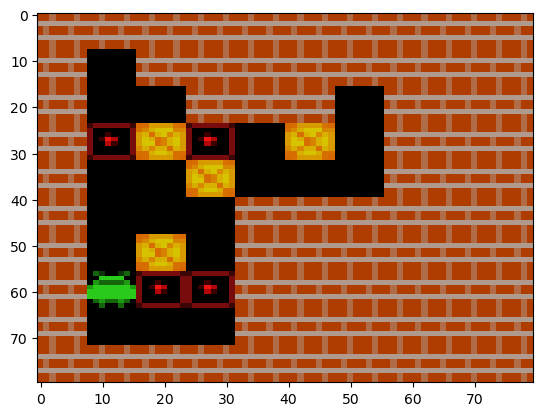

In [ ]:
a = torch.tensor([4,2,0]).long().unsqueeze(0).unsqueeze(0)
env_out, model_state = env.step(a, model_net, model_state)
cur_t = env_out.cur_t
x = env_out.gym_env_out[0]
plot_gym_env_out(x)
print(env_out.cur_t, env_out.see_mask, env.env.baseline_max_q)
device = torch.device("cuda")
actor_net.to(device)
actor_state = util.tuple_map(actor_state, lambda x: x.to(device))
env_out = util.tuple_map(env_out, lambda x: x.to(device))

out, actor_state = actor_net(env_out, actor_state)
print([x.dtype for x in out[0] if x is not None])


In [ ]:
k = 3
t = 4
n = 1
next_ind = np.array([3, np.nan, np.nan])

base_ind = 2 * n
base_ind_pri = t * base_ind

abs_flat_inds = np.array([6 + base_ind_pri, 5 + base_ind_pri])

# compute the correct index to update; if the indexes are across blocks,
# we have to carry the overflowing index to the next block

flat_inds = abs_flat_inds - base_ind_pri # get the relative index
mask = flat_inds > 0 
flat_inds = flat_inds[mask] 

flat_inds = flat_inds[:, np.newaxis] + np.arange(k) # flat_inds now stores uncarried indexes
flat_inds_block = flat_inds // (t * n) # block index of flat_inds
carry_mask = ~(flat_inds_block[:,[0]] == flat_inds_block).reshape(-1) 
# if first index block is not the same as the later index block, we need to carry it

flat_inds = flat_inds.reshape(-1)
flat_inds_block = flat_inds_block.reshape(-1)
carry_inds_block = next_ind[flat_inds_block[carry_mask]-1] - base_ind // n  # the correct index block

flat_inds = flat_inds.astype(float)
flat_inds[carry_mask] = flat_inds[carry_mask] + (-flat_inds_block[carry_mask] + carry_inds_block) * (t * n) 
mask = ~np.isnan(flat_inds)
flat_inds = flat_inds[mask].astype(int)
print(flat_inds_block)
print(carry_mask)
print(carry_inds_block)
print(flat_inds)

[1 1 2 1 1 1]
[False False  True False False False]
[nan]
[6 7 5 6 7]


In [ ]:

flags = util.parse([])
flags.model_batch_size = 2
flags.model_buffer_n = 1000
flags.model_warm_up_n = 500
flags.model_batch_mode = False
flags.model_rnn = True
flags.model_unroll_length = 8
t = flags.model_unroll_length   
flags.model_k_step_return = 5
k = flags.model_k_step_return
flags.actor_parallel_n = 1
n = flags.actor_parallel_n  

flags.model_batch_mode = True

P = namedtuple("P", ["x","y"])
model_buffer = ModelBuffer(flags)

c = 0
for c in range(100):
    data = P(torch.full((t+k, n, 1),c), torch.full((t+k, n, 1),c+0.1))    
    state = (torch.full((n, 3),c+0.2), torch.full((n, 3),c+0.3))
    model_buffer.write(data, state, np.random.randint(10))

print(model_buffer.next_inds)
data, data_state, weights, abs_flat_inds, inds = model_buffer.read(1)
print(data.x[:, :, -1], data_state)

state = tuple(torch.zeros_like(x) for x in data_state)
priorities = torch.zeros(len(abs_flat_inds))

model_buffer.update_priority(abs_flat_inds, priorities, state)



In [ ]:
from thinker.env import Environment
from thinker.net import ModelNet

flags = util.parse([])
flags.model_rnn = True

model_net_1 = ModelNet((3,80,80), 5, flags)
nc = model_net_1
print("network size: ", sum(p.numel() for p in nc.parameters()))

flags.model_rnn = False
model_net_2 = ModelNet((3,80,80), 5, flags)
nc = model_net_2
print("network size: ", sum(p.numel() for p in nc.parameters()))

network size:  841223
network size:  2352882


In [ ]:
tran = {"conv1":  "output_rvpi.conv1",
        "conv2":  "output_rvpi.conv2",
        "policy": "output_rvpi.fc_logits",
        "baseline": "output_rvpi.fc_v",
        "r": "output_rvpi.fc_r",
        "frame_conv.0":  "output_rvpi.conv1",
        "frame_conv.2":  "output_rvpi.conv2",}

state_dict = {}
for k in model_net_1.state_dict().keys():
    #print(k)
    if k not in model_net_2.state_dict().keys():
        for p, q in tran.items():
            if k[:len(p)+1] == p+".":
                out = q + k[len(p):]
                break
    else:
        out = k
    state_dict[k] = model_net_2.state_dict()[out]

model_net_1.load_state_dict(state_dict)
model_net_1.train(False)
model_net_2.train(False)

x = torch.rand(4, 3, 80, 80) * 2555
actions = torch.zeros(1, 4, dtype=torch.long)
done = torch.zeros(1, 4, dtype=torch.bool)

state = model_net_1.init_state(4)
vs, logits, states = model_net_1(x=x.unsqueeze(0), actions=actions, done=done, state=state)
print(logits)

rs, vs, logits, encodeds = model_net_2(x=x, actions=actions)
print(logits)

tensor([[[ 0.0005,  0.0253,  0.0640,  0.0987, -0.0419],
         [ 0.0010,  0.0284,  0.0646,  0.0968, -0.0359],
         [ 0.0019,  0.0287,  0.0614,  0.0948, -0.0363],
         [ 0.0028,  0.0284,  0.0636,  0.0960, -0.0396]]],
       grad_fn=<ViewBackward0>)
tensor([[[ 0.0005,  0.0253,  0.0640,  0.0987, -0.0419],
         [ 0.0010,  0.0284,  0.0646,  0.0968, -0.0359],
         [ 0.0019,  0.0287,  0.0614,  0.0948, -0.0363],
         [ 0.0028,  0.0284,  0.0636,  0.0960, -0.0396]]],
       grad_fn=<CatBackward0>)
